In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback, TypeNumberCallback,
)
from lib.sde.grn.grn import GRNMain
from lib.sde.mutate import EvolvableMutator

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time
from jf.utils.helper import provide_id

In [3]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")
_MUTATE_FUNC = EvolvableMutator()

In [4]:
def individual_generator(id_=-1, cb_init=None):
    sol = Solution(GRNMain(7, 5, 1, generate_funcs=cb_init), id_=id_)
    sol.grn.set_mutable()
    sol.grn.genes[0].init = 1
    for gene in sol.grn.genes:
        gene.noise = max(1, gene.noise)
    sol.grn.compile()
    sol.grn.var = dict(
        temperature_param=0.1,
        sparsity_param=0.2,
        temperature_tree=0.1,
        sparsity_tree=0.2,
    )
    return sol

In [5]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        _MUTATE_FUNC(self.grn)

In [6]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_infra, ref_n = normalize_time(stats, ref_stats, "infra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    stats_supra, _ = normalize_time(stats, ref_stats, "supra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    time_switch = 70.0
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_infra = stats_infra.set_index("time")
    stats_supra = stats_supra.set_index("time")
    
    prog_early = stats_p.loc[min(last_time_stats, time_switch)]["progenitor_pop_size"]
    neuron_infra_early = stats_infra.loc[min(last_time_stats, time_switch)]["infra_pop_size"]
    neuron_supra_early = stats_supra.loc[min(last_time_stats, time_switch)]["supra_pop_size"]
    
    prog_late = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    neuron_infra_late = stats_infra.loc[last_time_stats]["infra_pop_size"]
    neuron_supra_late = stats_supra.loc[last_time_stats]["supra_pop_size"]
    
    ref_prog_early = ref_p.loc[time_switch]["progenitor_pop_size"]
    ref_neuron_infra_early = ref_n.loc[time_switch]["neuron_pop_size"]
    ref_neuron_supra_early = 0.0
    
    ref_prog_late = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    ref_neuron_infra_late = ref_neuron_infra_early
    ref_neuron_supra_late = ref_n.loc[last_time_ref]["neuron_pop_size"] - ref_neuron_infra_late
    
    delta_late = (abs(prog_late - ref_prog_late) + abs(neuron_infra_late - ref_neuron_infra_late)
                  + abs(neuron_supra_late - ref_neuron_supra_late))
    delta_early = (abs(prog_early - ref_prog_early) + abs(neuron_infra_early - ref_neuron_infra_early)
                  + abs(neuron_supra_early - ref_neuron_supra_early))

    return 1 / max(1, 100 - 1 * delta_late - 0.5 * delta_early)

In [7]:
def hook_event_handler(cell_program):
    # prob **2 and **4
    q = np.array(cell_program.quantities)
    if random() < (q[0] / 2)**4:  # missing a reset
        cell_program.quantities = cell_program.quantities.at[0].set(0)
        return Action.Divide, GRNCell.Progenitor
    
    if random() < (q[1] / 2)**1.5 * (1 - q[2] / 2)**1.5:
        return Action.DiffNeuron, GRNCell.PostMitoticInfra
    
    if random() < (q[2] / 2)**1.5 * (1 - q[1] / 2)**1.5:
        return Action.DiffNeuron, GRNCell.PostMitoticSupra
    
    return Action.NoOp, None

In [8]:
def get_bb(prun, grn):
    from submodels.grn_auto_v1 import GRNCell
    ccls = factories["grn_auto1"](grn=grn, hooks=dict(event_handler=hook_event_handler))
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        infra_pop_size=TypeNumberCallback(GRNCell.PostMitoticInfra, TargetPopulation.whole),
        supra_pop_size=TypeNumberCallback(GRNCell.PostMitoticSupra, TargetPopulation.whole),
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=prun.start_time, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks)
    return bb

In [9]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [10]:
def fitness_step(prun, grn, step):
    bb = get_bb(prun, grn)
    bb.run_until(step.end_time)
    score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
    fitness = 1.0 / score_step
        
    return fitness, bb.stats

In [11]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_step(prun, sol.grn, prun.step)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=10., id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [12]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_step = ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2)

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50
    start_time = 56

def get_prun(size=7, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.step = example_step
    return prun

In [13]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [14]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if batch_gen == prun.n_gen:
        print("Already finished")
        return
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // prun.batch_size
            exporter(pop[-prun.batch_size:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [15]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [16]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "test_refacto8"
res = main(prun)

Exporting at output/test_refacto8
[definition] 
    
    
[out] Step 0
[out] ++ Best 68.65883024562089 for generation 0
[out] ++ Best 69.0465853476617 for generation 1
Saving ...
[out] ++ Best 82.08048802877913 for generation 59
[out] ++ Best 82.79477374306484 for generation 60
[out] ++ Best 83.94889639859318 for generation 66
[out] ++ Best 84.04073313328705 for generation 93
Saving ...
[out] Step 100
[out] ++ Best 84.54073313328705 for generation 104
Saving ...
[out] ++ Best 86.30603925573602 for generation 161
[out] ++ Best 87.0966447304252 for generation 191
Saving ...
[out] Step 200
[out] ++ Best 87.3570596638993 for generation 227
[out] ++ Best 87.60195762308297 for generation 241
[out] ++ Best 88.2777105219372 for generation 248
Saving ...
[out] ++ Best 88.53052905165441 for generation 281
Saving ...
[out] Step 300
[out] ++ Best 89.03876518276695 for generation 344
Saving ...
[out] ++ Best 89.4897127251238 for generation 380
[out] ++ Best 90.1563229733839 for generation 385
Savin

In [17]:
exp = Exporter(name=prun.name)

Exporting at output/test_refacto8


In [18]:
sm = read_model("generation")

In [19]:
res = pick_best(exp.load("generation_g26"))
# res = pick_best(exp.load(pick_last(exp)))

In [20]:
res.fit

89.73461068430746

In [21]:
# for i in range(5):
#     print(fitness_multistep(prun, res.grn, prun.steps))

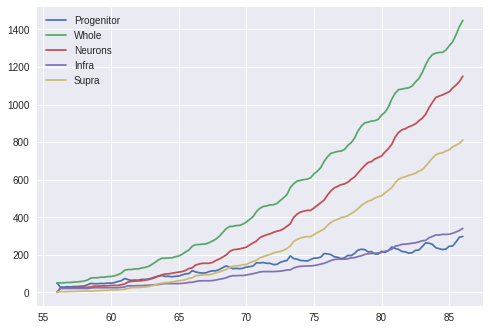

In [22]:
def quick_show(stats):
    plt.plot(stats.time, stats.progenitor_pop_size, label="Progenitor")
    plt.plot(stats.time, stats.whole_pop_size, label="Whole")
    plt.plot(stats.time, stats.neuron_pop_size, label="Neurons")
    plt.plot(stats.time, stats.infra_pop_size, label="Infra")
    plt.plot(stats.time, stats.supra_pop_size, label="Supra")
    plt.legend()
    
quick_show(res.stats)

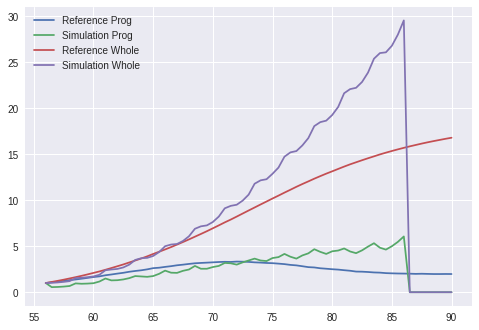

In [23]:
show_curve(res.stats, REF.stats)

In [24]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} {res.fit} =======")
    print(res.grn)


======= GENERATION generation_g1 82.00576902113109 =======
G> G_0: b=2.45; m=4.42; theta=5.20; init=1.00; noise=1.00; expr=0.98; deg=0.10; asym=5.00; tree=()
G> G_1: b=2.84; m=4.65; theta=1.18; init=1.34; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(1.00x0z AND 0.39x3 AND -0.74x1 AND -0.13x0)
G> G_2: b=2.08; m=1.41; theta=6.14; init=0.91; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(0.67x2 AND 0.56x0z AND -0.77x1)
G> G_3: b=1.92; m=2.00; theta=7.93; init=0.07; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(0.35x0z AND -0.42x3 AND 0.44x2)
G> G_4: b=2.68; m=5.27; theta=3.68; init=0.96; noise=1.00; expr=1.20; deg=0.10; asym=5.00; tree=(-0.14x0 AND 0.45x0z)
G> G_5: b=0.44; m=0.02; theta=6.92; init=1.01; noise=1.00; expr=1.00; deg=0.10; asym=3.96; tree=(0.60x1 AND -0.90x2 AND 1.00x4)
G> G_6: b=1.62; m=4.16; theta=3.73; init=1.01; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(0.67x4 AND -0.63x2 AND 0.41x0z)
R> tree=(0.51x4 OR -0.72x1 OR 0.59x1z OR -0.02x2)
R> tree=()
R> tre

In [25]:
def metrics_bb_size(bb, ref, *args, **kwargs):
    d = O()
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_infra, ref_n = normalize_time(stats, ref_stats, "infra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    stats_supra, _ = normalize_time(stats, ref_stats, "supra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    time_switch = 64.0
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_infra = stats_infra.set_index("time")
    stats_supra = stats_supra.set_index("time")
    
    d.prog_early = stats_p.loc[min(last_time_stats, time_switch)]["progenitor_pop_size"]
    d.neuron_infra_early = stats_infra.loc[min(last_time_stats, time_switch)]["infra_pop_size"]
    d.neuron_supra_early = stats_supra.loc[min(last_time_stats, time_switch)]["supra_pop_size"]
    
    d.prog_late = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    d.neuron_infra_late = stats_infra.loc[last_time_stats]["infra_pop_size"]
    d.neuron_supra_late = stats_supra.loc[last_time_stats]["supra_pop_size"]
    
    d.ref_prog_early = ref_p.loc[time_switch]["progenitor_pop_size"]
    d.ref_neuron_infra_early = ref_n.loc[time_switch]["neuron_pop_size"]
    d.ref_neuron_supra_early = 0.0
    
    d.ref_prog_late = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    d.ref_neuron_infra_late = d.ref_neuron_infra_early
    d.ref_neuron_supra_late = ref_n.loc[last_time_ref]["neuron_pop_size"] - d.ref_neuron_infra_late
    
    metrics = pd.DataFrame({
        "value": [d.prog_early, d.neuron_infra_early, d.neuron_supra_early,
                  d.prog_late, d.neuron_infra_late, d.neuron_supra_late],
        "ref": [d.ref_prog_early, d.ref_neuron_infra_early, d.ref_neuron_supra_early,
                d.ref_prog_late, d.ref_neuron_infra_late, d.ref_neuron_supra_late],
        "coeff": [0.5, 0.5, 0.5, 1, 1, 1],
    }, index=["prog_early", "neuron_infra_early", "neuron_supra_early",
                "prog_late", "neuron_infra_late", "neuron_supra_late"])
    
    metrics["metrics"] = (metrics["value"] - metrics["ref"]).apply(abs) * metrics["coeff"]
    
    return metrics

def score_metrics_bb_size(metrics):
    return 1 / max(1, 10000 - metrics["metrics"].sum())

In [26]:
metrics_bb_size(res, REF)

,value,ref,coeff,metrics
prog_early,3.061224,2.383750,0.5,0.338737
neuron_infra_early,0.795918,3.481867,0.5,1.342974
neuron_supra_early,1.510204,0.000000,0.5,0.755102
prog_late,3.061224,1.976666,1.0,1.084559
neuron_infra_late,5.020408,3.481867,1.0,1.538541
neuron_supra_late,17.551020,21.423109,1.0,3.872089
